# 이미지 인식을 위한 Transfomer

### 학습으로 각각의 10개의 category를 가진 60000개의 image사용 (32*32)
### CIFAR-100은 100개

In [1]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
num_classes = 100
input_shape = (32, 32, 3)

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

169001437/169001437 [==============================] - 3s 0us/step


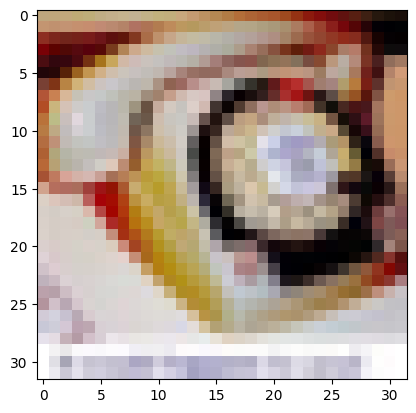

In [17]:
import matplotlib.pyplot as plt

plt.imshow(x_train[5])

In [6]:
## 파라미터
learning_rate = 0.001
## 가중치 감쇠
### overfittion 억
weight_decay = 0.0001
batch_size = 128
image_size = 72 #->> 이미지 사이즈를 72로 resize
### cnn 커널/필터는 전체이미지가 아니라 한번에 하나의 patch만을 처리
## 특징을 감지하기 위해 이미지의 작은 부분을 처리하기 위함
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4 ## 멀티헤드를 위한 hhead수

In [7]:
(image_size // patch_size) ** 2

144

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

## Patches
### 특정 이미지를 144개의 patch로 나눠 특징을 추출

In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Patch Encoder
## 이미지의 여러 차원을 나타내는 여러 patch를 가짐
## 이 patch들의 encoding을 가자ㅣㅁ

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [18]:
input_shape

(32, 32, 3)

## 아키텍쳐

In [32]:
inputs = layers.Input(shape=input_shape)

augmented = data_augmentation(inputs)

patches = Patches(patch_size)(augmented)
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
## encoder part
x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
attention_output = layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=projection_dim, dropout=0.1
)(x1, x1)
x2 = layers.Add()([attention_output, encoded_patches])
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
x3 = layers.Dense(128, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
x3 = layers.Dense(64, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
encoded_patches = layers.Add()([x3, x2])

In [33]:
x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
attention_output = layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=projection_dim, dropout=0.1
)(x1, x1)
x2 = layers.Add()([attention_output, encoded_patches])
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
x3 = layers.Dense(128, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
x3 = layers.Dense(64, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
encoded_patches = layers.Add()([x3, x2])

x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
attention_output = layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=projection_dim, dropout=0.1
)(x1, x1)
x2 = layers.Add()([attention_output, encoded_patches])
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
x3 = layers.Dense(128, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
x3 = layers.Dense(64, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
encoded_patches = layers.Add()([x3, x2])

x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
attention_output = layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=projection_dim, dropout=0.1
)(x1, x1)
x2 = layers.Add()([attention_output, encoded_patches])
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
x3 = layers.Dense(128, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
x3 = layers.Dense(64, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
encoded_patches = layers.Add()([x3, x2])

x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
attention_output = layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=projection_dim, dropout=0.1
)(x1, x1)
x2 = layers.Add()([attention_output, encoded_patches])
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
x3 = layers.Dense(128, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
x3 = layers.Dense(64, activation=tf.nn.gelu)(x3)
x3 = layers.Dropout(0.1)(x3)
encoded_patches = layers.Add()([x3, x2])

## Decoder Part

In [34]:
representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.5)(representation)
# Add MLP.
features = layers.Dense(2048, activation=tf.nn.gelu)(representation)
features = layers.Dropout(0.5)(features)
features = layers.Dense(1024, activation=tf.nn.gelu)(representation)
features = layers.Dropout(0.5)(features)
# Classify outputs.
logits = layers.Dense(num_classes)(features)


# Create the Keras model.
representation = layers.LayerNormalization(epsilon=1e-6)(logits)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.5)(representation)
# Add MLP.
features = layers.Dense(2048, activation=tf.nn.gelu)(representation)
features = layers.Dropout(0.5)(features)
features = layers.Dense(1024, activation=tf.nn.gelu)(representation)
features = layers.Dropout(0.5)(features)
# Classify outputs.
logits = layers.Dense(num_classes)(features)


# Create the Keras model.
representation = layers.LayerNormalization(epsilon=1e-6)(logits)
represenrepresentation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.5)(representation)
# Add MLP.
features = layers.Dense(2048, activation=tf.nn.gelu)(representation)
features = layers.Dropout(0.5)(features)
features = layers.Dense(1024, activation=tf.nn.gelu)(representation)
features = layers.Dropout(0.5)(features)
# Classify outputs.
logits = layers.Dense(num_classes)(features)


# Create the Keras model.
tation = layers.Flatten()(logits)
representation = layers.Dropout(0.5)(representation)
# Add MLP.
features = layers.Dense(2048, activation=tf.nn.gelu)(representation)
features = layers.Dropout(0.5)(features)
features = layers.Dense(1024, activation=tf.nn.gelu)(representation)
features = layers.Dropout(0.5)(features)
# Classify outputs.
logits = layers.Dense(num_classes)(features)


# Create the Keras model.
representation = layers.LayerNormalization(epsilon=1e-6)(logits)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.5)(representation)
# Add MLP.
features = layers.Dense(2048, activation=tf.nn.gelu)(representation)
features = layers.Dropout(0.5)(features)
features = layers.Dense(1024, activation=tf.nn.gelu)(representation)
features = layers.Dropout(0.5)(features)
# Classify outputs.
logits = layers.Dense(num_classes)(features)
# Create the Keras model.


In [35]:
model = keras.Model(inputs=inputs, outputs=logits)

In [36]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

##from_logits =True
### 특정 레이어에서 최종 예측을 수행하지 않겠다는 것
model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics="accuracy")
## model fit에서 또한 검증으로 쓰일수 있음
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=5,
    validation_split=0.2
)

Epoch 1/5
313/313 [==============================] - 51s 137ms/step - loss: 4.5660 - accuracy: 0.0188 - val_loss: 4.3184 - val_accuracy: 0.0303
Epoch 2/5
 55/313 [====>.........................] - ETA: 31s - loss: 4.3333 - accuracy: 0.0286

KeyboardInterrupt: ignored

In [14]:
_, accuracy = model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 3.2111 - accuracy: 0.2168


In [15]:
accuracy

0.2168000042438507

In [16]:
0.2467000037431717 * 100

24.67000037431717

In [20]:
history.history

{'loss': [4.404506206512451,
  3.9515976905822754,
  3.7761335372924805,
  3.6597249507904053,
  3.542098045349121],
 'accuracy': [0.05587499961256981,
  0.09369999915361404,
  0.11612500250339508,
  0.13420000672340393,
  0.1526000052690506],
 'val_loss': [3.8216850757598877,
  3.6059625148773193,
  3.428887128829956,
  3.303135633468628,
  3.224890947341919],
 'val_accuracy': [0.11729999631643295,
  0.15320000052452087,
  0.18320000171661377,
  0.2012999951839447,
  0.21950000524520874]}

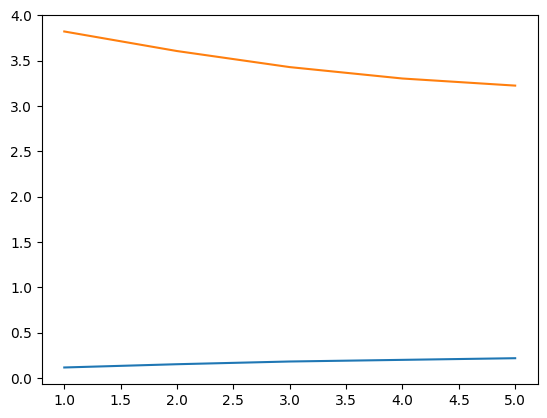

In [26]:
plt.plot([t+1 for t in range(5)],history.history['val_accuracy'])
plt.plot([t+1 for t in range(5)],history.history['val_loss'])

### 바닐라 트랜스포머를 이용해서 vision문제를 해결하는 것은 그리 권장되는 방법이 아님

## 비전트랜스포머를 이용해서 예측해야함